### Steps needed for training
- 0.1
- 0.3
- 1
- 2
- 3
- 4.1
- 4.2

### Steps needed for testing
- 0.2
- 0.3
- 1
- 2
- 4.1
- 5 (uploading the model takes a lot of time)

## Step 0: Environment and data setup


### Step 0.1: Upload images and masks for **training** (skip if you just want to evaluate your images)

Images and masks can have any dimensions, as they will be resized to 1024x1024 later. However, they must be in PNG format.

In [2]:
# Upload the images to content/data/original_images_train
# NB! Images need to be in .png format
from google.colab import files
import os
os.makedirs('/content/data/original_images_train', exist_ok=True)

uploaded = files.upload()

for fn in uploaded.keys():
  os.rename(fn, '/content/data/original_images_train/' + fn)

Saving 001.png to 001.png
Saving 002.png to 002.png
Saving 006.png to 006.png
Saving 007.png to 007.png
Saving 008.png to 008.png
Saving 009.png to 009.png
Saving 010.png to 010.png
Saving 011.png to 011.png
Saving 012.png to 012.png
Saving 013.png to 013.png
Saving 014.png to 014.png
Saving 015.png to 015.png
Saving 016.png to 016.png
Saving 017.png to 017.png
Saving 018.png to 018.png
Saving 019.png to 019.png
Saving 021.png to 021.png
Saving 022.png to 022.png
Saving 031.png to 031.png
Saving 032.png to 032.png
Saving 033.png to 033.png
Saving 035.png to 035.png
Saving 039.png to 039.png
Saving 040.png to 040.png
Saving 041.png to 041.png
Saving 046.png to 046.png
Saving 050.png to 050.png
Saving 057.png to 057.png
Saving 062.png to 062.png
Saving 065.png to 065.png
Saving 066.png to 066.png


In [3]:
# Upload the masks content/data/original_masks_train
# NB! Masks need to be in .png format
os.makedirs('/content/data/original_masks_train', exist_ok=True)

uploaded = files.upload()

for fn in uploaded.keys():
  os.rename(fn, '/content/data/original_masks_train/' + fn)

### Step 0.2: Upload images and masks for **test** (skip if you just want to train your model)

Images and masks can have any dimensions, as they will be resized to 1024x1024 later. However, they must be in PNG format.

In [4]:
from google.colab import files
import os
os.makedirs('/content/data/original_images_test', exist_ok=True)

uploaded = files.upload()

for fn in uploaded.keys():
  os.rename(fn, '/content/data/original_images_test/' + fn)

In [5]:
from google.colab import files
import os
os.makedirs('/content/data/original_masks_test', exist_ok=True)

uploaded = files.upload()

for fn in uploaded.keys():
  os.rename(fn, '/content/data/original_masks_test/' + fn)

### Step 0.3 Adjusting images and masks to 1024x1024

This step is done to avoid streching and morphing the images.

If the input image (e.g., PNG or JPG) is not already in **1024x1024** format, it will be adjusted using the following logic:

1. **Shorter Edges**:  
   - If any dimension (width or height) is smaller than 1024, black pixels (background) will be added to pad the image to the correct size.

2. **Tiling Logic for Larger Images**:  
   - If the image is larger than 1024x1024, it will be split into **overlapping tiles**:
     - Each tile has a size of **1024x1024**.
     - **Overlap**: Tiles may overlap slightly to account for edge misalignments and ensure complete coverage.
     - **Step Size**: The step size is dynamically calculated based on the image dimensions and the desired tile size to minimize unused areas. (vb ebavajalik lause)
     - Tiles are saved with filenames indicating their original name and tile indices (e.g., `image_tile_0_1.png`).


If you are wondering why extra background is added as a way to solve the problem with dimensions then I don't have a good answer. We had a chat among the team members and it sounded like an ok idea which was fairly easy to implement.

In [6]:
# Convert the images into 1024x1024

import os
import numpy as np
from PIL import Image

def process_directory_with_tiling(input_dir, output_dir, final_size=1024):
    """
    Processes a directory of images, splits them into 1024x1024 tiles,
    and saves them with original filenames appended with tile indices.

    Args:
        input_dir (str): Path to input directory containing images.
        output_dir (str): Directory to save the tiles.
        final_size (int): Desired tile size (default 1024).
    """
    os.makedirs(output_dir, exist_ok=True)

    # Supported file extensions
    supported_extensions = ['.png', '.jpg', '.jpeg']

    def compute_positions_and_step(dim_length, tile_size):
        """Calculate positions and steps for tiling with overlap."""
        if dim_length <= tile_size:
            return [0]  # No tiling needed
        splits = max(1, dim_length // tile_size)
        residue = dim_length % tile_size
        step = tile_size if residue == 0 else tile_size - residue // splits
        start_positions = list(range(0, dim_length - tile_size + 1, step))
        if start_positions[-1] + tile_size < dim_length:
            start_positions.append(dim_length - tile_size)
        return start_positions

    # Iterate over all files in the input directory
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)

        # Process only supported image files
        if not any(filename.lower().endswith(ext) for ext in supported_extensions):
            continue  # Skip unsupported files

        # Load image
        img = Image.open(file_path).convert("RGB")
        img = np.asarray(img)
        original_shape = img.shape

        height, width, channels = original_shape
        final_h, final_w = final_size, final_size

        # Compute start positions for tiling
        start_positions_x = compute_positions_and_step(height, final_h)
        start_positions_y = compute_positions_and_step(width, final_w)

        # Process and save tiles
        tile_count = 0
        base_filename = os.path.splitext(filename)[0]  # Remove file extension
        for x_idx, start_x in enumerate(start_positions_x):
            for y_idx, start_y in enumerate(start_positions_y):
                # Extract the tile
                end_x = min(start_x + final_h, height)
                end_y = min(start_y + final_w, width)
                tile = img[start_x:end_x, start_y:end_y]

                # Pad if tile is smaller than 1024x1024
                tile_h, tile_w = tile.shape[:2]
                padded_tile = np.zeros((final_h, final_w, channels), dtype=tile.dtype)
                padded_tile[:tile_h, :tile_w, :] = tile

                # Save the tile with modified filename
                tile_name = f"{base_filename}_tile_{x_idx}_{y_idx}.png"
                tile_path = os.path.join(output_dir, tile_name)
                Image.fromarray(padded_tile).save(tile_path)
                tile_count += 1

        print(f"Processed {tile_count} tiles for image: {filename}")

In [7]:
# Tiling for train images (skip if you just want to evaluate your model)
process_directory_with_tiling("/content/data/original_masks_train", "/content/data/masks", final_size=1024)
process_directory_with_tiling("/content/data/original_images_train", "/content/data/images", final_size=1024)

Processed 2 tiles for image: 012.png
Processed 1 tiles for image: 050.png
Processed 2 tiles for image: 018.png
Processed 1 tiles for image: 031.png
Processed 2 tiles for image: 021.png
Processed 2 tiles for image: 014.png
Processed 2 tiles for image: 015.png
Processed 1 tiles for image: 046.png
Processed 2 tiles for image: 017.png
Processed 1 tiles for image: 066.png
Processed 2 tiles for image: 001.png
Processed 2 tiles for image: 002.png
Processed 2 tiles for image: 009.png
Processed 1 tiles for image: 065.png
Processed 1 tiles for image: 035.png
Processed 2 tiles for image: 008.png
Processed 1 tiles for image: 057.png
Processed 1 tiles for image: 062.png
Processed 2 tiles for image: 016.png
Processed 2 tiles for image: 019.png
Processed 2 tiles for image: 010.png
Processed 1 tiles for image: 040.png
Processed 2 tiles for image: 013.png
Processed 1 tiles for image: 033.png
Processed 1 tiles for image: 039.png
Processed 1 tiles for image: 032.png
Processed 2 tiles for image: 022.png
P

In [8]:
# Tiling for test images (skip if you just want to train your model)
process_directory_with_tiling("/content/data/original_masks_test", "/content/data/masks_test", final_size=1024)
process_directory_with_tiling("/content/data/original_images_test", "/content/data/images_test", final_size=1024)

Processed 2 tiles for image: 003.png
Processed 1 tiles for image: 061.png
Processed 2 tiles for image: 020.png
Processed 1 tiles for image: 004.png
Processed 2 tiles for image: 003.png
Processed 1 tiles for image: 061.png
Processed 2 tiles for image: 020.png
Processed 1 tiles for image: 004.png


## Step 1: Install SAM-2
To start the fine-tuning process, we need to install the SAM-2 library, which is crucial for the Segment Anything Model (SAM2). This model is designed to handle various segmentation tasks effectively. The installation involves cloning the SAM-2 repository from GitHub and installing the necessary dependencies.

In [9]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -q -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (412/412), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1057 (delta 271), reused 246 (delta 246), pack-reused 645 (from 2)
Receiving objects: 100% (1057/1057), 121.74 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (384/384), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:

## Step 2: Download SAM-2 checkpoints
For the fine-tuning process, we need to start with pre-trained SAM2 model weights. These weights, called "checkpoints," are the starting point for further training. The checkpoints have been trained on a wide range of images, and by fine-tuning them on our specific dataset, we can achieve better performance on our target tasks.

In [23]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
!wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

--2024-12-19 12:43:00--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.102, 108.157.254.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   205MB/s    in 0.7s    

2024-12-19 12:43:00 (205 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2024-12-19 12:43:01--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.102, 108.157.254.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (1

## Step 3: Data preparation
With the dataset in place, the next step is to prepare it for training. This involves splitting the dataset into training and testing sets and creating data structures that can be fed into the SAM 2 model during fine-tuning.

In [24]:
# Creatin of train.csv
import os
import pandas as pd

# Path to the folder containing the mask files
input_folder = "/content/data/images"

# Scan the folder and get all filenames
new_filenames = sorted([file for file in os.listdir(input_folder) if file.endswith(('.jpg', '.png'))])

# Create a DataFrame with ImageId and MaskId columns (identical values)
new_train = pd.DataFrame({
    'ImageId': new_filenames,
    'MaskId': new_filenames
})

# Save the new train.csv file
output_file = "/content/data/train.csv"
new_train.to_csv(output_file, index=False)

# Print success message and display first few rows
print(f"train.csv generated successfully with {len(new_filenames)} entries.")
print(new_train.head())

train.csv generated successfully with 50 entries.
            ImageId            MaskId
0  001_tile_0_0.png  001_tile_0_0.png
1  001_tile_0_1.png  001_tile_0_1.png
2  002_tile_0_0.png  002_tile_0_0.png
3  002_tile_0_1.png  002_tile_0_1.png
4  006_tile_0_0.png  006_tile_0_0.png


In [25]:
%cd /content/segment-anything-2

import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Path to the chest-ct-segmentation dataset folder
data_dir = "/content/data"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

# Load the train.csv file
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

# Split the data into two halves: one for training and one for testing
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare the training data list
train_data = []
for index, row in train_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   train_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })


/content/segment-anything-2


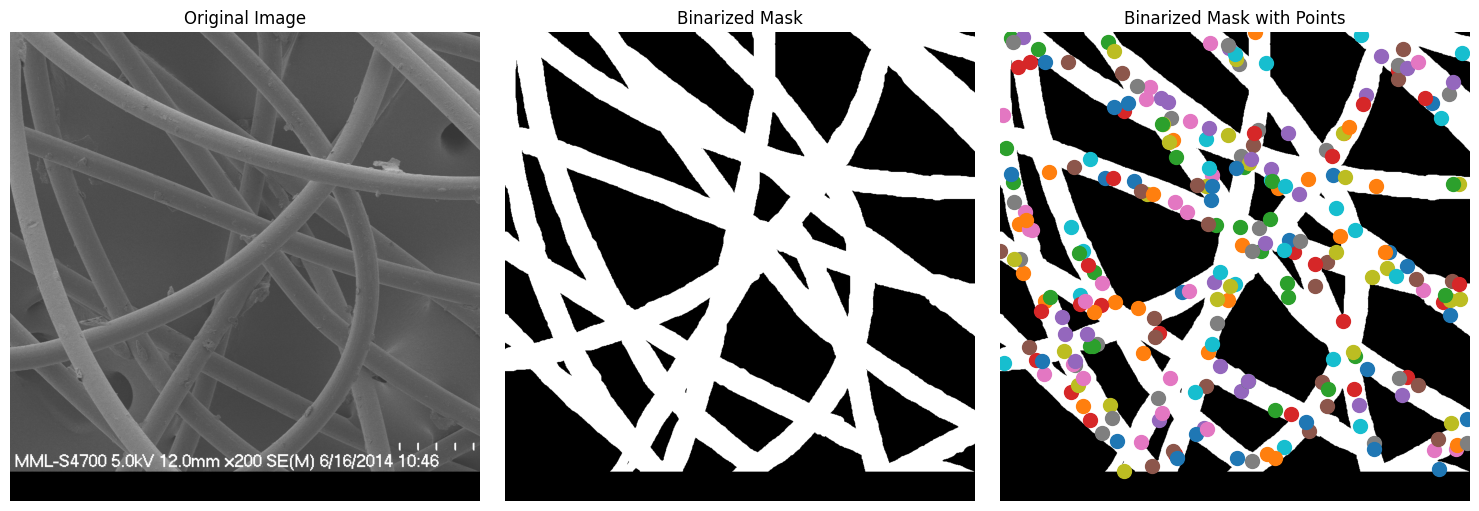

In [26]:
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    ### Continuation of read_batch() ###

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

        ### Continuation of read_batch() ###

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)




## Step 4: Model training

### Step 4.1: Initializing the model

In [27]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "sam2_hiera_large.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_l.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

### Step 4.2: Training the model

In [28]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(), lr=5e-4, weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 700 # @param

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"


<ipython-input-28-d9b619940a66>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [29]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.02  # Reduced IoU loss weight


       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


<ipython-input-29-f2bf4d799af9>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.4630055043751007
Step 200:	 Accuracy (IoU) =  0.6890408512089149
Step 300:	 Accuracy (IoU) =  0.7914424259361066
Step 400:	 Accuracy (IoU) =  0.8266028542790994
Step 500:	 Accuracy (IoU) =  0.840343336565102
Step 600:	 Accuracy (IoU) =  0.8593968754507447
Step 700:	 Accuracy (IoU) =  0.8560946333849335
Step 800:	 Accuracy (IoU) =  0.8612756995505845
Step 900:	 Accuracy (IoU) =  0.8555567179714622
Step 1000:	 Accuracy (IoU) =  0.8471184257470057


In [ ]:
# (Optional) Download the model
FINE_TUNED_MODEL_NAME = "/content/fine_tuned_sam2_adjusted_final.torch"
torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL_NAME)
print(f"Final model weights saved to {FINE_TUNED_MODEL_NAME}")

Final model weights saved to /content/fine_tuned_sam2_adjusted_final.torch


In [ ]:
# (Optional) Export the model to H5 (haven't tested if works properly)
import torch
import h5py

# Define paths
FINE_TUNED_MODEL_NAME = "/content/fine_tuned_sam2_adjusted_final.torch"
H5_MODEL_NAME = "/content/fine_tuned_sam2_adjusted_final.h5"

# Save PyTorch model as .torch
torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL_NAME)
print(f"Final model weights saved to {FINE_TUNED_MODEL_NAME}")

# Load the model weights
state_dict = predictor.model.state_dict()

# Save model in HDF5 (.h5) format
with h5py.File(H5_MODEL_NAME, "w") as h5_file:
    for key, value in state_dict.items():
        # Convert the tensor to numpy before saving
        h5_file.create_dataset(key, data=value.cpu().numpy())

print(f"Model successfully saved in HDF5 format to {H5_MODEL_NAME}")

Final model weights saved to /content/fine_tuned_sam2_adjusted_final.torch
Model successfully saved in HDF5 format to /content/fine_tuned_sam2_adjusted_final.h5


## Step 5: Visualizing results

### (Optional) Step 5.1: Upload the model


In [12]:
# Upload the model (if you didn't train one)
# This is a bit slow. Idk how to make it faster rn. Training the model itself takes like 7 min
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_adjusted_final.torch"  # or your desired filename

uploaded = files.upload()

for fn in uploaded.keys():
  # Assuming the uploaded file is the model weights
  if fn == FINE_TUNED_MODEL_WEIGHTS or fn.endswith(".torch"):
    # Save the uploaded file to the current directory or a specific location
    # You can modify the path if needed
    # with open(FINE_TUNED_MODEL_WEIGHTS, 'wb') as f:
    #   f.write(uploaded[fn])
    os.rename(fn, FINE_TUNED_MODEL_WEIGHTS) # Assuming you want the file named FINE_TUNED_MODEL_WEIGHTS
    print(f"Model uploaded and saved as {FINE_TUNED_MODEL_WEIGHTS}")
    break  # Exit the loop after saving the model weights
  else:
    print(f"Uploaded file '{fn}' does not match the expected model filename.")

KeyboardInterrupt: 

### Step 5.2: Visualizing and saving the results

In [30]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

<ipython-input-40-f91a3e0248e8>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))


Saved predicted mask for 003_tile_0_0.png as /content/data/predicted_masks/003_tile_0_0.png
Saved predicted mask for 003_tile_0_1.png as /content/data/predicted_masks/003_tile_0_1.png
Saved predicted mask for 004_tile_0_0.png as /content/data/predicted_masks/004_tile_0_0.png
Saved predicted mask for 020_tile_0_0.png as /content/data/predicted_masks/020_tile_0_0.png
Saved predicted mask for 020_tile_0_1.png as /content/data/predicted_masks/020_tile_0_1.png
Saved predicted mask for 061_tile_0_0.png as /content/data/predicted_masks/061_tile_0_0.png


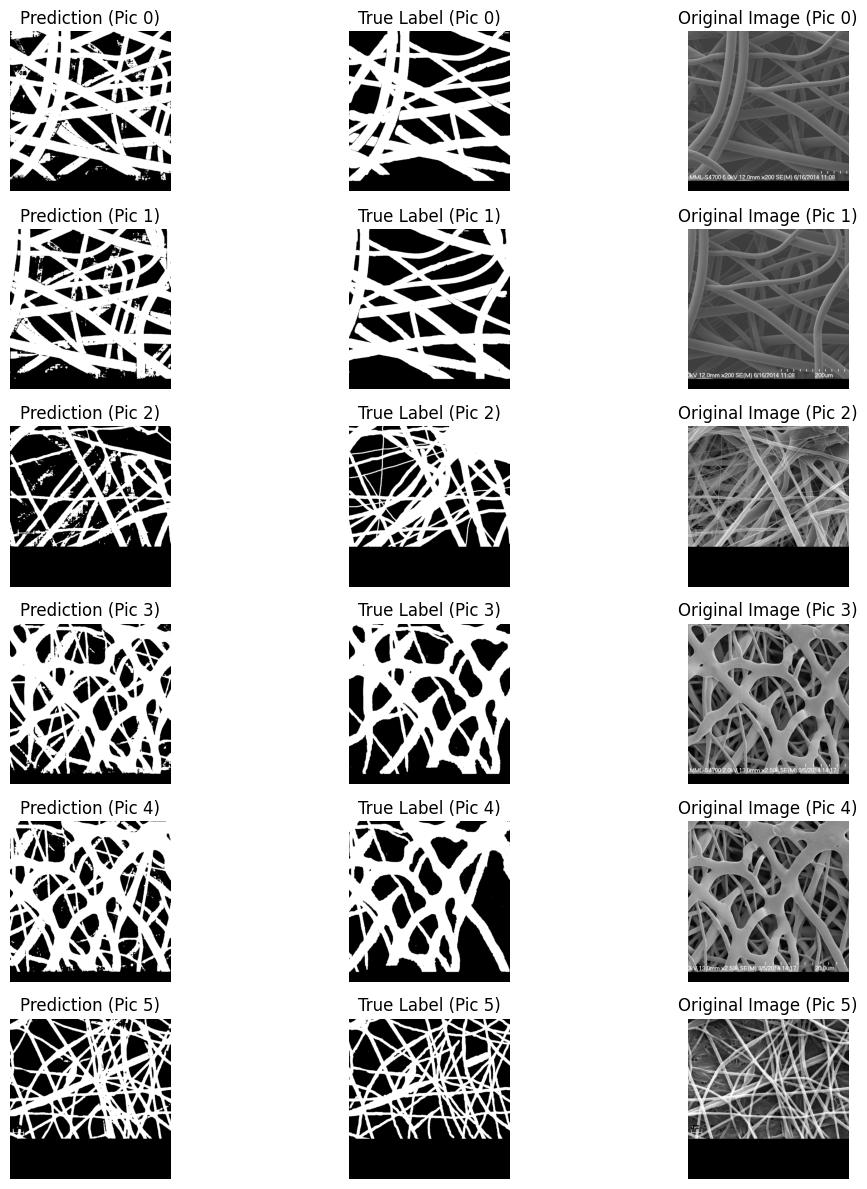

In [40]:
# Visualizing the results and saving predicted masks as PNGs

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Define paths to test images and masks
test_images_dir = "/content/data/images_test"
test_masks_dir = "/content/data/masks_test"
output_predicted_masks_dir = "/content/data/predicted_masks"  # Directory to save predicted masks
os.makedirs(output_predicted_masks_dir, exist_ok=True)

# List all test images and masks
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg") or f.endswith(".png")])
test_mask_files = sorted([f for f in os.listdir(test_masks_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Logic for the initial solution
# Load the fine-tuned model (only once, outside the loop for efficiency)
FINE_TUNED_MODEL_WEIGHTS = "/content/segment-anything-2/fine_tuned_sam2_700.torch" # this part can be problematic sometimes
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Number of images to display in a grid
num_images_to_display = 6

# Create a figure for grid visualization
fig, axes = plt.subplots(num_images_to_display, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.05)

for idx, (image_file, mask_file) in enumerate(zip(test_image_files, test_mask_files)):
    if idx >= num_images_to_display:  # Show only the specified number of images
        break

    # Paths to the current image and mask
    image_path = os.path.join(test_images_dir, image_file)
    mask_path = os.path.join(test_masks_dir, mask_file)

    # Load the image and mask
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))  # Convert mask to grayscale

    # Generate random points for the input
    num_samples = 30  # Number of points per segment to sample
    input_points = get_points(mask, num_samples)

    # Perform inference and predict masks
    with torch.no_grad():
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=np.ones([input_points.shape[0], 1])
        )

    # Process the predicted masks and sort by scores
    np_masks = np.array(masks[:, 0])
    np_scores = scores[:, 0]
    sorted_masks = np_masks[np.argsort(np_scores)][::-1]

    # Initialize segmentation map and occupancy mask
    seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
    occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

    # Combine masks to create the final segmentation map
    for i in range(sorted_masks.shape[0]):
        mask_pred = sorted_masks[i]
        if (mask_pred * occupancy_mask).sum() / mask_pred.sum() > 0.15:
            continue

        mask_bool = mask_pred.astype(bool)
        mask_bool[occupancy_mask] = False
        seg_map[mask_bool] = 1  # Use single mask for visualization
        occupancy_mask[mask_bool] = True

    # Save the predicted mask as a PNG
    predicted_mask_path = os.path.join(output_predicted_masks_dir, f"{os.path.splitext(image_file)[0]}.png")
    Image.fromarray((seg_map * 255).astype(np.uint8)).save(predicted_mask_path)

    # Visualization: Prediction, True Mask, Original Image
    axes[idx, 0].imshow(seg_map, cmap='gray')
    axes[idx, 0].set_title(f'Prediction (Pic {idx})')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(mask, cmap='gray')
    axes[idx, 1].set_title(f'True Label (Pic {idx})')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(image)
    axes[idx, 2].set_title(f'Original Image (Pic {idx})')
    axes[idx, 2].axis('off')

    print(f"Saved predicted mask for {image_file} as {predicted_mask_path}")

# Display the grid
plt.tight_layout()
plt.show()

In [41]:
# Reasembling logic
import os
import numpy as np
from PIL import Image

def compute_positions_and_step(dim_length, tile_size):
    """Calculate positions and steps for tiling with overlap."""
    if dim_length <= tile_size:
        return [0]  # No tiling needed
    splits = max(1, dim_length // tile_size)
    residue = dim_length % tile_size
    step = tile_size if residue == 0 else tile_size - residue // splits
    start_positions = list(range(0, dim_length - tile_size + 1, step))
    if start_positions[-1] + tile_size < dim_length:
        start_positions.append(dim_length - tile_size)
    return start_positions

def reassemble_mask_from_tiles(
    original_image_path,
    predicted_tiles_dir,
    final_size=1024,
    output_mask_path="reconstructed_mask.png"
):
    """
    Reassembles the predicted mask from tiled predictions.

    Args:
        original_image_path (str): Path to the original full-sized image.
        predicted_tiles_dir (str): Directory containing the predicted mask tiles.
        final_size (int): Tile size used during splitting (default 1024).
        output_mask_path (str): Where to save the reassembled mask.
    """
    # Load original image to get dimensions
    original_img = Image.open(original_image_path).convert("RGB")
    original_arr = np.asarray(original_img)
    height, width, _ = original_arr.shape

    # Recompute the start positions for tiling
    start_positions_x = compute_positions_and_step(height, final_size)
    start_positions_y = compute_positions_and_step(width, final_size)

    # Initialize the reconstructed mask
    reconstructed_mask = np.zeros((height, width), dtype=np.uint8)

    # Base filename from the input image
    base_filename = os.path.splitext(os.path.basename(original_image_path))[0]

    # Identify relevant tiles for the base filename
    tile_files = sorted([
        f for f in os.listdir(predicted_tiles_dir)
        if f.startswith(base_filename) and "_tile_" in f and f.endswith(".png")
    ])

    # Map tiles by their (x_idx, y_idx)
    tile_map = {}
    for tile_file in tile_files:
        parts = tile_file.split("_tile_")
        if len(parts) != 2:
            continue
        x_y = parts[1].replace(".png", "")
        x_idx_str, y_idx_str = x_y.split("_")
        x_idx, y_idx = int(x_idx_str), int(y_idx_str)
        tile_map[(x_idx, y_idx)] = tile_file

    # Reassemble the mask
    for (x_idx, x_start) in enumerate(start_positions_x):
        for (y_idx, y_start) in enumerate(start_positions_y):
            # Original tile dimensions before padding
            end_x = min(x_start + final_size, height)
            end_y = min(y_start + final_size, width)
            tile_h = end_x - x_start
            tile_w = end_y - y_start

            # Load the tile
            tile_filename = tile_map.get((x_idx, y_idx))
            if not tile_filename:
                continue  # Skip missing tiles

            tile_path = os.path.join(predicted_tiles_dir, tile_filename)
            tile_arr = np.asarray(Image.open(tile_path).convert("L"))

            # Crop the tile if necessary
            tile_cropped = tile_arr[:tile_h, :tile_w]

            # Place the cropped tile into the reconstructed mask
            reconstructed_mask[x_start:end_x, y_start:end_y] = tile_cropped

    # Save the reconstructed mask
    Image.fromarray(reconstructed_mask).save(output_mask_path)
    print(f"Reassembled mask saved to {output_mask_path}")

In [43]:
# Reasemble the predicted masks
import os

# Define directories
original_masks_dir = "/content/data/original_masks_test"
predicted_tiles_dir = "/content/data/predicted_masks"
reconstructed_masks_dir = "/content/data/reconstructed_predicted_masks"

# Ensure the output directory exists
os.makedirs(reconstructed_masks_dir, exist_ok=True)

# Loop through each mask in the original masks directory
for original_mask_file in os.listdir(original_masks_dir):
    if original_mask_file.endswith(".png"):  # Process only PNG files
        original_mask_path = os.path.join(original_masks_dir, original_mask_file)

        # Construct output path for the reconstructed mask
        reconstructed_mask_name = f"reconstructed_{original_mask_file}"
        output_mask_path = os.path.join(reconstructed_masks_dir, reconstructed_mask_name)

        # Call the function to reassemble the mask
        reassemble_mask_from_tiles(
            original_image_path=original_mask_path,
            predicted_tiles_dir=predicted_tiles_dir,
            final_size=1024,
            output_mask_path=output_mask_path
        )

Reassembled mask saved to /content/data/reconstructed_predicted_masks/reconstructed_003.png
Reassembled mask saved to /content/data/reconstructed_predicted_masks/reconstructed_061.png
Reassembled mask saved to /content/data/reconstructed_predicted_masks/reconstructed_020.png
Reassembled mask saved to /content/data/reconstructed_predicted_masks/reconstructed_004.png
